# Prepare audio dataset.

* Dataset downloaded from https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification.
* Dataset contents:
  - genres original: A collection of 10 genres with 100 audio files each, all having a length of 30 seconds.
  - images original: Mel Spectrograms of each audio file.
  - 2 CSV files: Containing features of the audio files. One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3 seconds audio files.
* A subset of the original dataset will be created and used for the calculations (genres_reduced).

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Explore dataset

In [18]:
import json
import os
import math
import librosa
import sys
import os
from os.path import join as jp
import numpy as np


audio_files_path = '/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/GTZAN_Data/genres_original'
mel_spectr_path = '/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/GTZAN_Data/images_original'

def explore_data(path, folder):
  """ Prints contents of dataset

      Parameters:
      path(str): path to data
      folder(str): name of folder containing data
  """
  print("\nPrinting contents for ", folder, "...")
  
  for root, dirs, files in os.walk(path, topdown=False):
    for name in dirs:
        print("Folder" , name, "contains ", len(os.listdir(os.path.join(root, name))), "files!")
  
  return 

explore_data(audio_files_path, "Genre folder")
explore_data(mel_spectr_path, "Mel spectrograms folder")

genre_names = [a for a in os.listdir(audio_files_path) if '.' not in a]
print("\nDataset contains ", len(genre_names), "genre categories:", genre_names)
      


Printing contents for  Genre folder ...
Folder pop contains  100 files!
Folder hiphop contains  100 files!
Folder jazz contains  100 files!
Folder blues contains  100 files!
Folder disco contains  100 files!
Folder classical contains  100 files!
Folder metal contains  100 files!
Folder rock contains  100 files!
Folder country contains  100 files!
Folder reggae contains  100 files!

Printing contents for  Mel spectrograms folder ...
Folder hiphop contains  100 files!
Folder classical contains  100 files!
Folder pop contains  100 files!
Folder disco contains  100 files!
Folder rock contains  100 files!
Folder country contains  100 files!
Folder jazz contains  99 files!
Folder reggae contains  100 files!
Folder blues contains  100 files!
Folder metal contains  100 files!

Dataset contains  10 genre categories: ['pop', 'hiphop', 'jazz', 'blues', 'disco', 'classical', 'metal', 'rock', 'country', 'reggae']


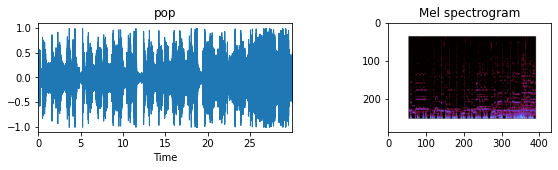

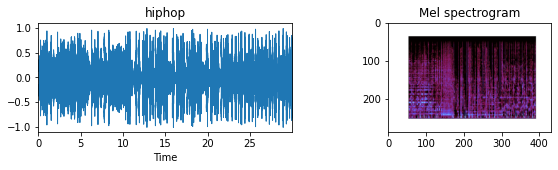

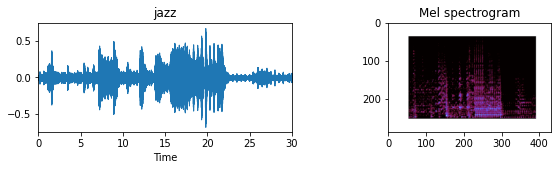

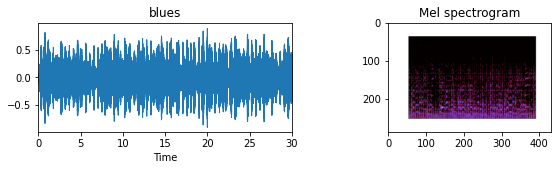

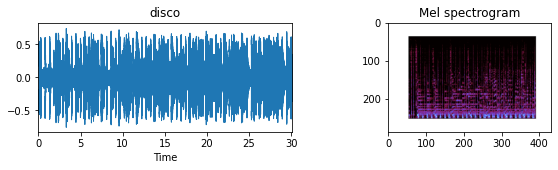

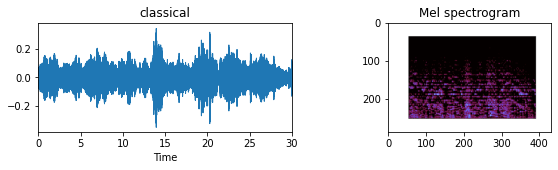

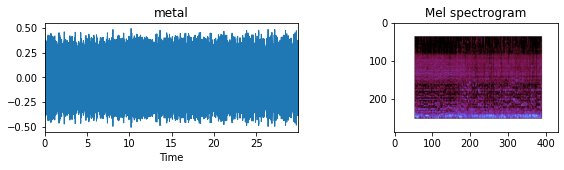

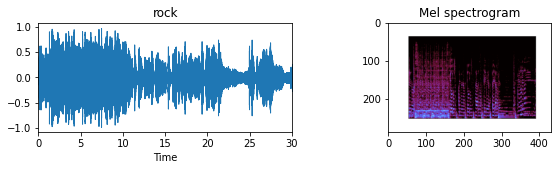

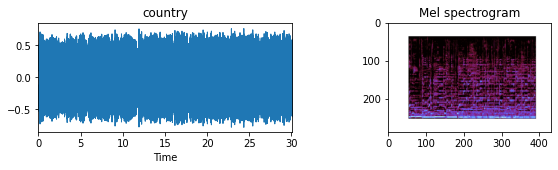

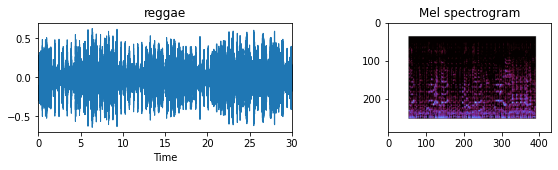

In [19]:
import cv2
import matplotlib.pyplot as plt
import librosa, librosa.display


# Plots

def plots():

  for g in genre_names:

    audio = jp(audio_files_path, g, ''.join((g, ".00000.wav")))
    mel = jp(mel_spectr_path, g, ''.join((g,'00000.png')))

    audio_signal, sample_rate = librosa.load(audio, sr=None)
    mel_img = cv2.imread(mel)
     
    plt.figure(figsize=(10, 2)) 
    plt.subplot(1,2,1)
    librosa.display.waveplot(audio_signal)
    plt.title(g)

    plt.subplot(1,2,2)
    plt.imshow(mel_img)
    plt.title("Mel spectrogram")
    plt.show()


if __name__ == "__main__":  
  plots()




## Create reduced version of dataset

In [21]:
import soundfile as sf

# Save genre names 
reduced_genres_path = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/GTZAN_Data/genres_reduced"


def create_reduced(genre_folders, num, orig_path, reduced_path):

   # Loop through genre folders
  for genres in genre_folders:

    # Create directory for saving spectrograms
    if not os.path.exists(jp(reduced_path, genres)):
      os.makedirs(jp(reduced_path, genres))

    # Get mel spectrograms names
    files_names = os.listdir(jp(orig_path, genres))
    
    # Load audio files and save them to new folder
    for i in range(0, num):
      audio, sample_rate = librosa.load(jp(orig_path, genres, files_names[i]), sr=None)   
      sf.write(jp(reduced_path,genres, files_names[i]), audio, sample_rate)

      print(files_names[i], "is saved!")
    print("\n")
    

# if __name__ == "__main__":  
  # create_reduced(genre_names, 10, audio_files_path, reduced_genres_path)

## Calculate different features of audio files.

* Audio files are 30 seconds long with a sampling rare of 22050 Hz.
* Each file will be first divided into 10, non-overlapping segments, of 3 second duration, in order to increase the dataset and possibly prevent over-fitting during training. 
* Different audio features will be extracted and saved for each of the segments

In [22]:
DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/GTZAN_Data/genres_reduced"
MFCC_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/mfcc_data.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

### (a) MFCC calculation

In [61]:
def mfcc_dataset(data_path, json_path, num_mfcc_coeffs=13, fft_window=2048, hop_length=512, num_segments=10):
   
    """ Extracts MFCCs for each audio segment  and saves them into json file.

        Parameters:
        data_path (str): path to dataset
        json_path(str): path to json file
        num_mfcc (int): num of MFFC coeffs to extract
        fft_window (int): window length for STFT
        hop_length (int): shift length for the sliding  window 
        num_segments (int): num of segments for each audio file    
    
    """
    # Used for dividing each audio into segments
    samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
    mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    # Dictionary for storing data
    data_dict = {"genres": [], "mfcc": [], "labels": []}

    # Loop through dataset directory
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

      if dirpath is not data_path:
      
        # Save genre names into dictionary
        genre_name = dirpath.split("/")[-1]
        data_dict['genres'].append(genre_name)
        # print("\nProcessing of genre", genre_name, "......")

        # Process audio files in genre subfolder
        for f in filenames:

          # Load audio file
          file_path = os.path.join(dirpath, f)
          signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

          # Segment audio file + extract mfcc for each segment
          for s in range(num_segments):

            # Calculate first and last sample of segment
            start_of_segment = samples_per_segment * s
            finish_of_segment = samples_per_segment * s +samples_per_segment
            segment = signal[start_of_segment:finish_of_segment]

            # Compute MFCC of the segment
            mfcc = librosa.feature.mfcc(segment, 
                                        sr = sample_rate, 
                                        n_mfcc = num_mfcc_coeffs,
                                        n_fft= fft_window,
                                        hop_length=hop_length)            
            mfcc = mfcc.T
            print(mfcc.shape, len(mfcc))

    #         # Save 
    #         if len(mfcc) == mfcc_vectors_per_segment:
    #           data_dict["mfcc"].append(mfcc.tolist())
    #           data_dict["labels"].append(i-1)
    #           # print("Saved segment ",s+1, "of file ", file_path)

    #     print("MFCC extraction for genre",genre_name, "is DONE!" )

    # # Save MFCCs to json file
    # with open(json_path, "w") as fp:
    #     json.dump(data_dict, fp, indent=4)
    # print("\nMFCCs are saved into json file...!")
        
if __name__ == "__main__":
    mfcc_dataset(DATA_PATH, MFCC_JSON_PATH)


# Check contents of json
with open(MFCC_JSON_PATH) as f:
  data = json.load(f)

  #  Iterate through json lists
  labels = data['labels']
  coeffs = data['mfcc']
  genres = data['genres']
  print("Shape of genre list is:",np.shape(genres))
  print("Shape of labels list is:",np.shape(labels))
  print("Shape of MFFC coeffs is:",np.shape(coeffs)) 



(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 13) 130
(130, 

KeyboardInterrupt: ignored

### (b) STFT calculation

In [ ]:
STFT_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/stft_data.json"

def stft_dataset(data_path, json_path, fft_window=2048, hop_length=512, num_segments=10):
   
    """ Extracts STFTS for each audio segment and saves them into json file.

        Parameters:
        data_path (str): path to dataset
        json_path(str): path to json file
        fft_window (int): window length for STFT
        hop_length (int): shift length for the sliding  window 
        num_segments (int): num of segments for each audio file    
    
    """
    # Used for dividing each audio into segments
    samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
    stft_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    # Dictionary for storing data
    data_dict = {"genres": [], "stft": [], "labels": []}

    # Loop through dataset directory
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

      if dirpath is not data_path:
      
        # Save genre names into dictionary
        genre_name = dirpath.split("/")[-1]
        data_dict['genres'].append(genre_name)
        # print("\nProcessing of genre", genre_name, "......")

        # Process audio files in genre subfolder
        for f in filenames:

          # Load audio file
          file_path = os.path.join(dirpath, f)
          signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

          # Segment audio file
          for s in range(num_segments):

            # Calculate first and last sample of segment
            start_of_segment = samples_per_segment * s
            finish_of_segment = samples_per_segment * s +samples_per_segment
            segment = signal[start_of_segment:finish_of_segment]

            # Compute STFT of the segment and cast to db
            stft = librosa.stft(segment, n_fft=fft_window, hop_length=hop_length)
            spectrogram = np.abs(stft)
            log_spectrogram = librosa.amplitude_to_db(spectrogram)

            # Save 
            if len(log_spectrogram) == stft_vectors_per_segment:
              data_dict["stft"].append(log_spectrogram.tolist())
              data_dict["labels"].append(i-1)

        print("STFT extraction for genre",genre_name, "is DONE!" )

    # Save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data_dict, fp, indent=4)
    print("\nSTFTs are saved into json file...!")


if __name__ == "__main__":
    stft_dataset(DATA_PATH, STFT_JSON_PATH)

    # Check contents of json
    with open(STFT_JSON_PATH) as f:
      data = json.load(f)

    #  Iterate through json lists
    labels = data['labels']
    stft = data['stft']
    genres = data['genres']
    print("Shape of genre list is:",np.shape(genres))
    print("Shape of labels list is:",np.shape(labels))
    print("Shape of STFT is:",np.shape(coeffs)) 

### (c) Mel Spectrograms

In [63]:
MEL_JSON_PATH = "/content/drive/MyDrive/Colab Notebooks/Music_Genre_Classification/mel_data.json"

def mel_dataset(data_path, json_path, num_mels=10, fft_window=2048, hop_length=512, sample_rate=SAMPLE_RATE, num_segments=10):
   
    """ Extracts MFCCs for each audio segment  and saves them into json file.

        Parameters:
        data_path (str): path to dataset
        json_path(str): path to json file
        num_mels (int): num of mels
        fft_window (int): window length for STFT
        hop_length (int): shift length for the sliding  window 
        sample_rate (int): sample rate of audio files
        num_segments (int): num of segments for each audio file    
    
    """
    # Used for dividing each audio into segments
    samples_per_segment = int(SAMPLES_PER_TRACK/num_segments)
    mel_vectors_per_segment = math.ceil(samples_per_segment / hop_length) # 130

    # Dictionary for storing data
    data_dict = {"genres": [], "mel": [], "labels": []}

    # Loop through dataset directory
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_path)):

      if dirpath is not data_path:
      
        # Save genre names into dictionary
        genre_name = dirpath.split("/")[-1]
        data_dict['genres'].append(genre_name)

        # Process audio files in genre subfolder
        for f in filenames:

          # Load audio file
          file_path = os.path.join(dirpath, f)
          signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

          # Segment audio file + extract mfcc for each segment
          for s in range(num_segments):

            # Calculate first and last sample of segment
            start_of_segment = samples_per_segment * s
            finish_of_segment = samples_per_segment * s +samples_per_segment
            segment = signal[start_of_segment:finish_of_segment]

            # Compute Mel spectrogram of the segment and cast to db
            mel_spectrogram = librosa.feature.melspectrogram(segment, sr=sample_rate, n_fft=fft_window, hop_length=hop_length, n_mels=num_mels)
            log_mel_spectrogram = librosa.power_to_db(mel_spectrogram) # --> shape(10,130) 
            log_mel_spectrogram = log_mel_spectrogram.T

            # Save 
            if len(log_mel_spectrogram) == mel_vectors_per_segment:
              data_dict["mel"].append(log_mel_spectrogram.tolist())
              data_dict["labels"].append(i-1)

        print("Mel spectrograms extraction for genre",genre_name, "is DONE!" )

    # Save Mel spectrograms to json file
    with open(json_path, "w") as fp:
        json.dump(data_dict, fp, indent=4)

    print("\nMel spectrograms are saved into json file...!")
        
if __name__ == "__main__":
    mel_dataset(DATA_PATH, MEL_JSON_PATH)

     # Check contents of json
    with open(MEL_JSON_PATH) as f:
      data = json.load(f)

    #  Iterate through json lists
    labels = data['labels']
    mel = data['mel']
    genres = data['genres']
    print("Shape of genre list is:",np.shape(genres))
    print("Shape of labels list is:",np.shape(labels))
    print("Shape of Mel spectrogram is:",np.shape(mel)) 



Mel spectrograms extraction for genre pop is DONE!
Mel spectrograms extraction for genre hiphop is DONE!
Mel spectrograms extraction for genre jazz is DONE!
Mel spectrograms extraction for genre blues is DONE!
Mel spectrograms extraction for genre disco is DONE!
Mel spectrograms extraction for genre classical is DONE!
Mel spectrograms extraction for genre metal is DONE!
Mel spectrograms extraction for genre rock is DONE!
Mel spectrograms extraction for genre country is DONE!
Mel spectrograms extraction for genre reggae is DONE!

Mel spectrograms are saved into json file...!
Shape of genre list is: (10,)
Shape of labels list is: (999,)
Shape of Mel spectrogram is: (999, 130, 10)


### Plots

Shape of MFCC data: (999, 130, 13)
(13, 130)


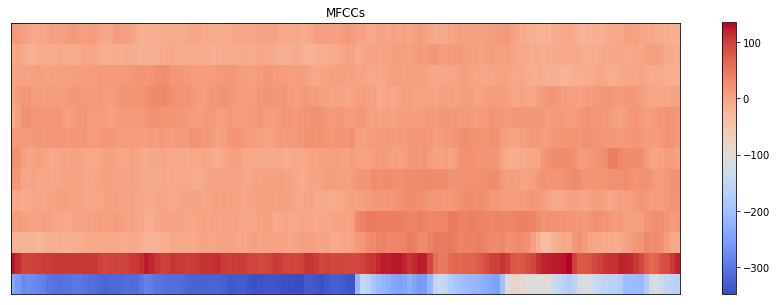

Shape of Mel spectrogram data: (999, 130, 10)
(10, 130)


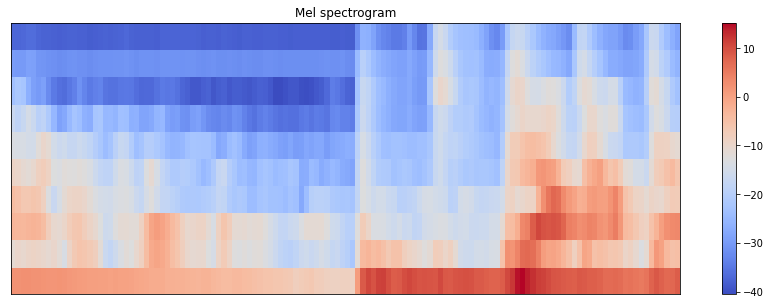

In [64]:
# MFCC data 
with open(MFCC_JSON_PATH) as f:
  data_mfcc = json.load(f)

mfcc = data_mfcc['mfcc']
print("Shape of MFCC data:", np.shape(mfcc))

mfcc1 = np.array(mfcc[0])
mfcc1 = mfcc1.T
print(mfcc1.shape)

plt.figure(figsize=(15, 5))
librosa.display.specshow(mfcc1, sr=SAMPLE_RATE)
plt.colorbar()
plt.title("MFCCs")
plt.show()


# Mel spectrogram data 
with open(MEL_JSON_PATH) as f:
  data_mel = json.load(f)

mel = data_mel['mel']
print("Shape of Mel spectrogram data:", np.shape(mel))

mel1 = np.array(mel[0])
mel1 = mel1.T
print(mel1.shape)

plt.figure(figsize=(15, 5))
librosa.display.specshow(mel1, sr=SAMPLE_RATE)
plt.colorbar()
plt.title("Mel spectrogram")
plt.show()


